## Data loading

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from scipy.sparse import coo_matrix,hstack
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import re
import pickle
from scipy.special import softmax

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/capstone-pimco/Part1/script

/content/drive/.shortcut-targets-by-id/1fxwDKXWkdB0AhrfygUa9ZwtDkZaAxnGZ/capstone-pimco/Part1/script


In [4]:
from direction_baseline_models.tool import *

Merge manual labelled direction files for each topic together and then drop the sentences whose topics are mislablled. Then use 'cleaned text' as X and 'topic' as y.

In [5]:
import glob
# @path: file stored all the manual direction tagged sentence
path = f"/content/drive/MyDrive/capstone-pimco/Part1/data/manual_direction_eng_completed/"
all_files = glob.glob(path + "/*.xlsx")
df_train = pd.concat((pd.read_excel(f, usecols=[1,2,3,4,5,6]) for f in all_files))
print(df_train)

                                       uncleaned_text  \
0   See, for example Justin Bloesch and Francois G...   
1   "An International Look at the Growth of Modern...   
2   I expect growth to come in a tad above 3 perce...   
3   Private nonfarm payroll employment increased 6...   
4   Economic activity and employment have continue...   
..                                                ...   
95  In the face of this instability, in 2008 and 2...   
96  Treasury securities are a convenient and natur...   
97  See, e.g., Board of Governors of the Federal R...   
98  "Central Bank Communication and Policy Effecti...   
99  In undertaking these steps, the Federal Reserv...   

                                                 text               topic  \
0   See, for example Justin Bloesch and Francois G...              growth   
1   "An International Look at the Growth of Modern...              growth   
2   Both consumer and business spending are making...              growth   
3   On 

In [6]:
df_train.reset_index(inplace = True,drop = True)

In [7]:
df_train

,uncleaned_text,text,topic,direction,true_topic,cleaned_text
0,"See, for example Justin Bloesch and Francois G...","See, for example Justin Bloesch and Francois G...",growth,0.0,Nan,"see, for example justin bloesch and francois g..."
1,"""An International Look at the Growth of Modern...","""An International Look at the Growth of Modern...",growth,0.0,Nan,an international look at the growth of modern ...
2,I expect growth to come in a tad above 3 perce...,Both consumer and business spending are making...,growth,1.0,NaN,both consumer and business spending are making...
3,Private nonfarm payroll employment increased 6...,"On the international trade front, recent readi...",growth,1.0,NaN,"on the international trade front, recent readi..."
4,Economic activity and employment have continue...,Economic activity and employment have continue...,growth,1.0,NaN,economic activity and employment have continue...
...,...,...,...,...,...,...
995,"In the face of this instability, in 2008 and 2...","In the face of this instability, in 2008 and 2...",liquidity measures,1.0,NaN,"in the face of this instability, in and policy..."
996,Treasury securities are a convenient and natur...,Treasury securities are a convenient and natur...,liquidity measures,1.0,NaN,treasury security are a convenient and natural...
997,"See, e.g., Board of Governors of the Federal R...",Board of Governors of the Federal Reserve Syst...,liquidity measures,1.0,NaN,board of governor of the federal reserve syste...
998,"""Central Bank Communication and Policy Effecti...","""Central Bank Communication and Policy Effecti...",liquidity measures,0.0,NaN,central bank communication and policy effectiv...


In [8]:
df_train = df_train[(df_train['true_topic'].isna()) &~( df_train['direction'].isna()) ]

In [9]:
df_train.topic.unique()

array(['growth', 'financial markets', 'fed funds rate', 'inflation',
       'labor market', 'housing', 'quantitative easing',
       'geopolitical uncertainty', 'credit', 'liquidity measures'],
      dtype=object)

In [10]:
X = df_train[(df_train['true_topic'].isna()) &~( df_train['direction'].isna()) ]['cleaned_text']

In [11]:
X

2      both consumer and business spending are making...
3      on the international trade front, recent readi...
4      economic activity and employment have continue...
7      the fact is that economic health is the sum of...
9      all told, i expect that the recovery in u  eco...
                             ...                        
995    in the face of this instability, in and policy...
996    treasury security are a convenient and natural...
997    board of governor of the federal reserve syste...
998    central bank communication and policy effectiv...
999    in undertaking these step, the federal reserve...
Name: cleaned_text, Length: 876, dtype: object

In [12]:
X.shape

(876,)

In [13]:
y = df_train[(df_train['true_topic'].isna()) &~( df_train['direction'].isna())]['direction'].astype('int')
y

2      1
3      1
4      1
7      0
9      1
      ..
995    1
996    1
997    1
998    0
999    0
Name: direction, Length: 876, dtype: int64

# Benchmark Models

Split train and test data and stratify on the topic label and then transform the text data to tf-idf vectors.

## Data preprocessing(TfidfVectorizer)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(X, y ,test_size=0.25, stratify = y,random_state=42)

In [15]:
df_train

,uncleaned_text,text,topic,direction,true_topic,cleaned_text
2,I expect growth to come in a tad above 3 perce...,Both consumer and business spending are making...,growth,1.0,NaN,both consumer and business spending are making...
3,Private nonfarm payroll employment increased 6...,"On the international trade front, recent readi...",growth,1.0,NaN,"on the international trade front, recent readi..."
4,Economic activity and employment have continue...,Economic activity and employment have continue...,growth,1.0,NaN,economic activity and employment have continue...
7,We have opportunities to partner with business...,The fact is that economic health is the sum of...,growth,0.0,NaN,the fact is that economic health is the sum of...
9,"However, with the firming of domestic demand, ...","All told, I expect that the recovery in U.S. e...",growth,1.0,NaN,"all told, i expect that the recovery in u eco..."
...,...,...,...,...,...,...
995,"In the face of this instability, in 2008 and 2...","In the face of this instability, in 2008 and 2...",liquidity measures,1.0,NaN,"in the face of this instability, in and policy..."
996,Treasury securities are a convenient and natur...,Treasury securities are a convenient and natur...,liquidity measures,1.0,NaN,treasury security are a convenient and natural...
997,"See, e.g., Board of Governors of the Federal R...",Board of Governors of the Federal Reserve Syst...,liquidity measures,1.0,NaN,board of governor of the federal reserve syste...
998,"""Central Bank Communication and Policy Effecti...","""Central Bank Communication and Policy Effecti...",liquidity measures,0.0,NaN,central bank communication and policy effectiv...


In [16]:
min_n = 1
max_n = 2
max_df = 0.8
k = None
tfidf_vec = TfidfVectorizer(ngram_range=(min_n,max_n),sublinear_tf=True,max_df=max_df,max_features = k)
tfidf_vec.fit(X_train)

TfidfVectorizer(max_df=0.8, ngram_range=(1, 2), sublinear_tf=True)

In [17]:
tfidf_X_train = tfidf_vec.transform(X_train)
tfidf_X_val = tfidf_vec.transform(X_val)

In [19]:
print(tfidf_X_train.shape)
print(tfidf_X_val.shape)
print(y_train.shape)
print(y_val.shape)

(657, 13379)
(219, 13379)
(657,)
(219,)


## metrics measurement

Metrics to measure model performance.

In [20]:
from sklearn.metrics import balanced_accuracy_score,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss,roc_auc_score
from sklearn.metrics import balanced_accuracy_score

ModelsPerformance = {}

def metricsReport(modelName,topic_name, test_labels, predictions):
    accuracy = accuracy_score(test_labels, predictions)
    balanced_accuracy = balanced_accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro')
    macro_recall = recall_score(test_labels, predictions, average='macro')
    macro_f1 = f1_score(test_labels, predictions, average='macro')

    weighted_precision = precision_score(test_labels, predictions, average='weighted')
    weighted_recall = recall_score(test_labels, predictions, average='weighted')
    weighted_f1 = f1_score(test_labels, predictions, average='weighted')

    micro_precision = precision_score(test_labels, predictions, average='micro')
    micro_recall = recall_score(test_labels, predictions, average='micro')
    micro_f1 = f1_score(test_labels, predictions, average='micro')
    roc = roc_auc_score
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName +"--"+ topic_name +"--"+ " Model Metrics-----")
    print("Accuracy: {:.4f}\nBalanced_Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\n - Weighted: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nWeighted: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nWeighted: {:.4f}"\
          .format(accuracy,balanced_accuracy, hamLoss, macro_precision, micro_precision,weighted_precision, macro_recall, micro_recall,weighted_recall, macro_f1, micro_f1, weighted_f1))
    ModelsPerformance[modelName] = micro_f1

## Logistic Regression

(1) Overall: Use logistic regression to classify the multi-class topics.

(2) Each topic: Split whole dataset into separate 10 topics and then use pre-trained logistic regression to make predicitons on each topic individually.

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [22]:
# solvers = ['sag','newton-cg', 'lbfgs', 'liblinear']
# penalty =  ['l1', 'l2','elasticnet']
import datetime
# result = pd.DataFrame({"topic":y_train.columns.values.tolist()})
# result = result.set_index("topic")
l1_ratio = [0, 0.5, 1]
c_values = [1, 0.01,100]
val_scores = []
parameters = []
for c in c_values:
  name = "c: {}".format(c)
  topic_name = []
  iter_res = []
  LogReg_pipeline = LogisticRegression(C = c,
                  max_iter = 100,
                  tol = 0.0001,
                  l1_ratio = 0,
                  fit_intercept = True,
                  penalty = 'l2',
                  multi_class='multinomial',
                  dual = False,
                  verbose = 0)
LogReg_pipeline.fit(tfidf_X_train, y_train)
prediction = LogReg_pipeline.predict(tfidf_X_val) 
accuracy_score(y_val, prediction)

0.634703196347032

In [23]:
prediction = LogReg_pipeline.predict(tfidf_X_val) 
metricsReport("logistic regression",'overall', y_val, prediction)


------logistic regression--overall-- Model Metrics-----
Accuracy: 0.6347
Balanced_Accuracy: 0.5206
Hamming Loss: 0.3653
Precision:
  - Macro: 0.5872
  - Micro: 0.6347
 - Weighted: 0.6151
Recall:
  - Macro: 0.5206
  - Micro: 0.6347
Weighted: 0.6347
F1-measure:
  - Macro: 0.5164
  - Micro: 0.6347
Weighted: 0.6033


In [24]:
for t in ['financial markets','geopolitical uncertainty','growth','housing','inflation','labor market','quantitative easing','credit','fed funds rate','liquidity measures']:
  y =  y_val.index.get_indexer_for(y_val[df_train.loc[y_val.index].topic == t].index)
  logistic_prediction = LogReg_pipeline.predict(tfidf_X_val[y,:])
  # tool.evaluate(y_val[df_train.loc[y_val.index].topic == t],prediction)
  metricsReport("logistic regression",t, y_val[df_train.loc[y_val.index].topic == t], logistic_prediction)

------logistic regression--financial markets-- Model Metrics-----
Accuracy: 0.7500
Balanced_Accuracy: 0.3077
Hamming Loss: 0.2500
Precision:
  - Macro: 0.2667
  - Micro: 0.7500
 - Weighted: 0.6500
Recall:
  - Macro: 0.3077
  - Micro: 0.7500
Weighted: 0.7500
F1-measure:
  - Macro: 0.2857
  - Micro: 0.7500
Weighted: 0.6964
------logistic regression--geopolitical uncertainty-- Model Metrics-----
Accuracy: 0.6522
Balanced_Accuracy: 0.4500
Hamming Loss: 0.3478
Precision:
  - Macro: 0.3917
  - Micro: 0.6522
 - Weighted: 0.6380
Recall:
  - Macro: 0.4500
  - Micro: 0.6522
Weighted: 0.6522
F1-measure:
  - Macro: 0.4119
  - Micro: 0.6522
Weighted: 0.6389
------logistic regression--growth-- Model Metrics-----
Accuracy: 0.5000
Balanced_Accuracy: 0.4722
Hamming Loss: 0.5000
Precision:
  - Macro: 0.6111
  - Micro: 0.5000
 - Weighted: 0.5278
Recall:
  - Macro: 0.4722
  - Micro: 0.5000
Weighted: 0.5000
F1-measure:
  - Macro: 0.5079
  - Micro: 0.5000
Weighted: 0.4921
------logistic regression--housing-

Calculate the overall roc_auc score

In [26]:
roc_auc_score(y_val, LogReg_pipeline.predict_proba(tfidf_X_val), multi_class='ovr')

0.7657712983114413

Draw the overall confusion matrix

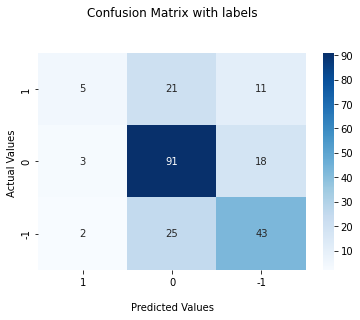

In [25]:
tool = visualization_tool()
tool.evaluate(y_val,prediction)

## KNN

(1) Overall: Use KNN to classify the multi-class topics.

(2) Each topic: Split whole dataset into separate 10 topics and then use pre-trained KNN model to make predicitons on each topic individually.

In [27]:
from sklearn.neighbors import KNeighborsClassifier

val_scores = []
neighbors = np.arange(1,40,2)
for idx in neighbors:
    knn = KNeighborsClassifier(n_neighbors = idx)
    knn.fit(tfidf_X_train,y_train)
    score = knn.score(tfidf_X_val, y_val)
    print(score)
    val_scores.append(score)

print(f"Best validation score:, {np.max(val_scores):.3f}")
best_n_neighbors = neighbors[np.argmax(val_scores)]
print("Best # of neighbors:" , best_n_neighbors)

0.5205479452054794
0.5205479452054794
0.589041095890411
0.5844748858447488
0.6027397260273972
0.5981735159817352
0.5981735159817352
0.5844748858447488
0.5753424657534246
0.593607305936073
0.6027397260273972
0.6073059360730594
0.5981735159817352
0.6027397260273972
0.6164383561643836
0.5981735159817352
0.593607305936073
0.593607305936073
0.589041095890411
0.593607305936073
Best validation score:, 0.616
Best # of neighbors: 29


In [ ]:
## knn
knnClf = KNeighborsClassifier(n_neighbors =best_n_neighbors)

knnClf.fit(tfidf_X_train, y_train)
knnPredictions = knnClf.predict(tfidf_X_val)
metricsReport("knn",'overall', y_val, knnPredictions)

------knn--overall-- Model Metrics-----
Accuracy: 0.6164
Balanced_Accuracy: 0.4775
Hamming Loss: 0.3836
Precision:
  - Macro: 0.7343
  - Micro: 0.6164
 - Weighted: 0.6757
Recall:
  - Macro: 0.4775
  - Micro: 0.6164
Weighted: 0.6164
F1-measure:
  - Macro: 0.4473
  - Micro: 0.6164
Weighted: 0.5606


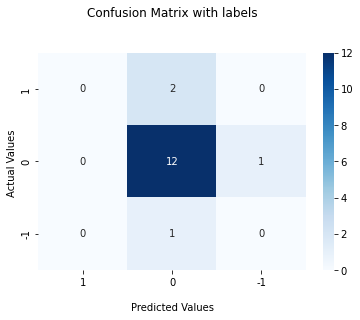

------knn--financial markets-- Model Metrics-----
Accuracy: 0.7500
Balanced_Accuracy: 0.3077
Hamming Loss: 0.2500
Precision:
  - Macro: 0.2667
  - Micro: 0.7500
 - Weighted: 0.6500
Recall:
  - Macro: 0.3077
  - Micro: 0.7500
Weighted: 0.7500
F1-measure:
  - Macro: 0.2857
  - Micro: 0.7500
Weighted: 0.6964


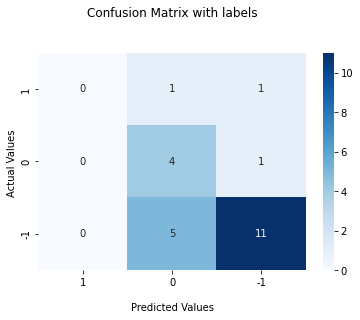

------knn--geopolitical uncertainty-- Model Metrics-----
Accuracy: 0.6522
Balanced_Accuracy: 0.4958
Hamming Loss: 0.3478
Precision:
  - Macro: 0.4154
  - Micro: 0.6522
 - Weighted: 0.6756
Recall:
  - Macro: 0.4958
  - Micro: 0.6522
Weighted: 0.6522
F1-measure:
  - Macro: 0.4307
  - Micro: 0.6522
Weighted: 0.6437


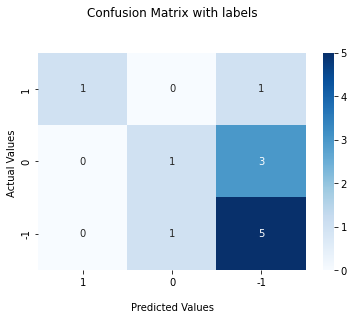

------knn--growth-- Model Metrics-----
Accuracy: 0.5833
Balanced_Accuracy: 0.5278
Hamming Loss: 0.4167
Precision:
  - Macro: 0.6852
  - Micro: 0.5833
 - Weighted: 0.6111
Recall:
  - Macro: 0.5278
  - Micro: 0.5833
Weighted: 0.5833
F1-measure:
  - Macro: 0.5556
  - Micro: 0.5833
Weighted: 0.5556


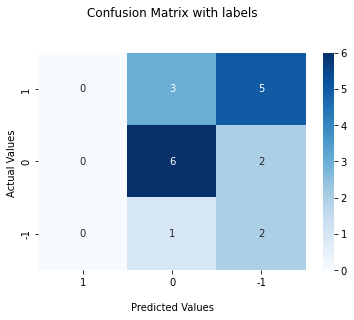

------knn--housing-- Model Metrics-----
Accuracy: 0.4211
Balanced_Accuracy: 0.4722
Hamming Loss: 0.5789
Precision:
  - Macro: 0.2741
  - Micro: 0.4211
 - Weighted: 0.2877
Recall:
  - Macro: 0.4722
  - Micro: 0.4211
Weighted: 0.4211
F1-measure:
  - Macro: 0.3333
  - Micro: 0.4211
Weighted: 0.3333


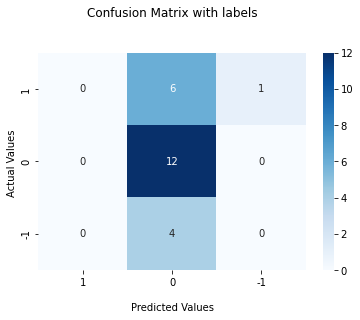

------knn--inflation-- Model Metrics-----
Accuracy: 0.5217
Balanced_Accuracy: 0.3333
Hamming Loss: 0.4783
Precision:
  - Macro: 0.1818
  - Micro: 0.5217
 - Weighted: 0.2846
Recall:
  - Macro: 0.3333
  - Micro: 0.5217
Weighted: 0.5217
F1-measure:
  - Macro: 0.2353
  - Micro: 0.5217
Weighted: 0.3683


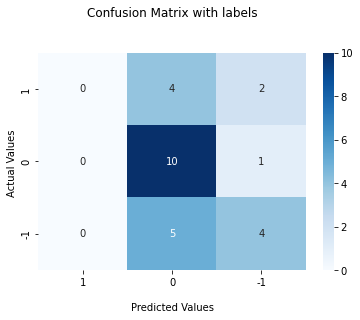

------knn--labor market-- Model Metrics-----
Accuracy: 0.5385
Balanced_Accuracy: 0.4512
Hamming Loss: 0.4615
Precision:
  - Macro: 0.3659
  - Micro: 0.5385
 - Weighted: 0.4205
Recall:
  - Macro: 0.4512
  - Micro: 0.5385
Weighted: 0.5385
F1-measure:
  - Macro: 0.3889
  - Micro: 0.5385
Weighted: 0.4551


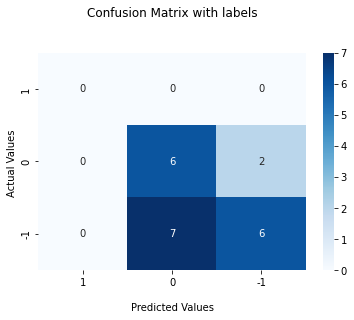

------knn--quantitative easing-- Model Metrics-----
Accuracy: 0.5714
Balanced_Accuracy: 0.6058
Hamming Loss: 0.4286
Precision:
  - Macro: 0.6058
  - Micro: 0.5714
 - Weighted: 0.6401
Recall:
  - Macro: 0.6058
  - Micro: 0.5714
Weighted: 0.5714
F1-measure:
  - Macro: 0.5714
  - Micro: 0.5714
Weighted: 0.5714


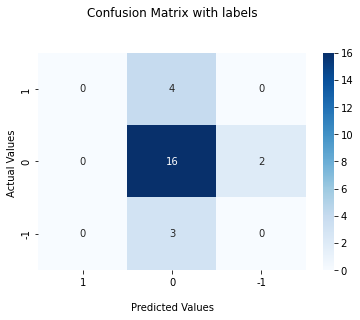

------knn--credit-- Model Metrics-----
Accuracy: 0.6400
Balanced_Accuracy: 0.2963
Hamming Loss: 0.3600
Precision:
  - Macro: 0.2319
  - Micro: 0.6400
 - Weighted: 0.5009
Recall:
  - Macro: 0.2963
  - Micro: 0.6400
Weighted: 0.6400
F1-measure:
  - Macro: 0.2602
  - Micro: 0.6400
Weighted: 0.5620


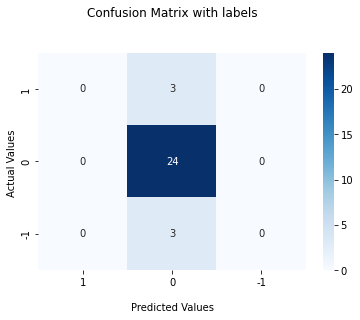

------knn--fed funds rate-- Model Metrics-----
Accuracy: 0.8000
Balanced_Accuracy: 0.3333
Hamming Loss: 0.2000
Precision:
  - Macro: 0.2667
  - Micro: 0.8000
 - Weighted: 0.6400
Recall:
  - Macro: 0.3333
  - Micro: 0.8000
Weighted: 0.8000
F1-measure:
  - Macro: 0.2963
  - Micro: 0.8000
Weighted: 0.7111


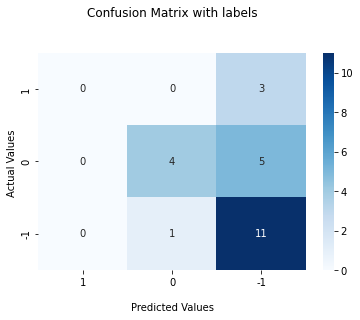

------knn--liquidity measures-- Model Metrics-----
Accuracy: 0.6250
Balanced_Accuracy: 0.4537
Hamming Loss: 0.3750
Precision:
  - Macro: 0.4596
  - Micro: 0.6250
 - Weighted: 0.5895
Recall:
  - Macro: 0.4537
  - Micro: 0.6250
Weighted: 0.6250
F1-measure:
  - Macro: 0.4270
  - Micro: 0.6250
Weighted: 0.5691


In [ ]:
for t in ['financial markets','geopolitical uncertainty','growth','housing','inflation','labor market','quantitative easing','credit','fed funds rate','liquidity measures']:
  y =  y_val.index.get_indexer_for(y_val[df_train.loc[y_val.index].topic == t].index)
  knnPredictions_per_topic = knnClf.predict(tfidf_X_val[y,:])
  tool.evaluate(y_val[df_train.loc[y_val.index].topic == t], knnPredictions_per_topic)
  metricsReport("knn", t,y_val[df_train.loc[y_val.index].topic == t], knnPredictions_per_topic)

Calculate overall roc_auc score.

In [ ]:
## knn
roc_auc_score(y_val, knnClf.predict_proba(tfidf_X_val), multi_class='ovr')

0.7439733243416677

Draw the overall confusion matrix.

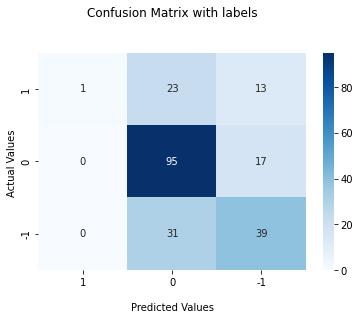

In [ ]:
tool.evaluate(y_val,knnPredictions)


##SVM

(1) Overall: Use SVM to classify the multi-class topics.

(2) Each topic: Split whole dataset into separate 10 topics and then use pre-trained SVM model to make predicitons on each topic individually.

In [ ]:
from sklearn import svm

C = np.logspace(-1,1,10)
val_scores = []
parameters = []

for c in C:
    clf =OneVsRestClassifier(svm.SVC(kernel='linear', C=c))
    clf.fit(tfidf_X_train, y_train)
    #print(clf.predict(tfidf_X_val) )
    print(clf.score(tfidf_X_val, y_val))
    val_scores.append(clf.score(tfidf_X_val, y_val))
    parameters.append(c)

print("Best test accuracy after hyperparameter tuning:", max(val_scores))

max_item = max(val_scores)
index = val_scores.index(max_item)
optimal_parameters = parameters[index]
print("The optimal parameter for svm is :", optimal_parameters)

0.5114155251141552
0.5114155251141552
0.5296803652968036
0.5662100456621004
0.6210045662100456
0.6438356164383562
0.6301369863013698
0.634703196347032
0.634703196347032
0.634703196347032
Best test accuracy after hyperparameter tuning: 0.6438356164383562
The optimal parameter for svm is : 1.291549665014884


In [ ]:
svmClf = OneVsRestClassifier(svm.SVC(kernel='linear', C=optimal_parameters))
svmClf.fit(tfidf_X_train, y_train)
svmPredictions = svmClf.predict(tfidf_X_val)
metricsReport("svm", 'overall',y_val, svmPredictions)

------svm--overall-- Model Metrics-----
Accuracy: 0.6438
Balanced_Accuracy: 0.5319
Hamming Loss: 0.3562
Precision:
  - Macro: 0.6323
  - Micro: 0.6438
 - Weighted: 0.6400
Recall:
  - Macro: 0.5319
  - Micro: 0.6438
Weighted: 0.6438
F1-measure:
  - Macro: 0.5270
  - Micro: 0.6438
Weighted: 0.6116


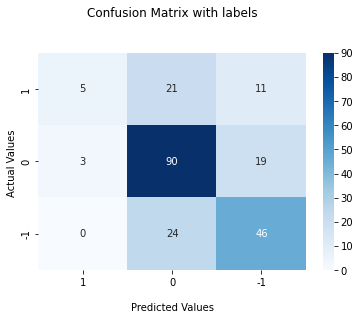

In [ ]:
tool.evaluate(y_val,svmPredictions)


## Random Forest

(1) Overall: Use Random Forest to classify the multi-class topics.

(2) Each topic: Split whole dataset into separate 10 topics and then use pre-trained random forest model to make predicitons on each topic individually.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline


# Create the parameter grid based on the results of random search 
param_grid = {
    'n_estimators': [50,100,150,200],
      #'n_estimators': [500,2000],
      'min_samples_split':[2,3,4],
     'max_features':[60,80,100,0.02,0.03,0.1],
     "class_weight" :["balanced"]
}
# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          refit=True,n_jobs=-1)

pipe_rf = make_pipeline(grid_search)
pipe_rf.fit(tfidf_X_train,y_train)
print("The best parameters are: "+ str(grid_search.best_params_))
print("The best test score is: "+ str(pipe_rf.score(tfidf_X_val,y_val)))


pipe_rf_best = grid_search.best_estimator_


y_pred = pipe_rf_best.fit(tfidf_X_train,y_train)
pipe_rf_best.predict(tfidf_X_val)
pipe_rf_best.score(tfidf_X_val,y_val)

The best parameters are: {'class_weight': 'balanced', 'max_features': 0.02, 'min_samples_split': 2, 'n_estimators': 100}
The best test score is: 0.5799086757990868


0.6118721461187214

In [ ]:
## random forest model with hyperparameter tuning
rfPredictions = pipe_rf_best.predict(tfidf_X_val)
metricsReport("random forest", 'overall',y_val, rfPredictions)

------random forest--overall-- Model Metrics-----
Accuracy: 0.5799
Balanced_Accuracy: 0.4287
Hamming Loss: 0.4201
Precision:
  - Macro: 0.7195
  - Micro: 0.5799
 - Weighted: 0.6499
Recall:
  - Macro: 0.4287
  - Micro: 0.5799
Weighted: 0.5799
F1-measure:
  - Macro: 0.3996
  - Micro: 0.5799
Weighted: 0.5103


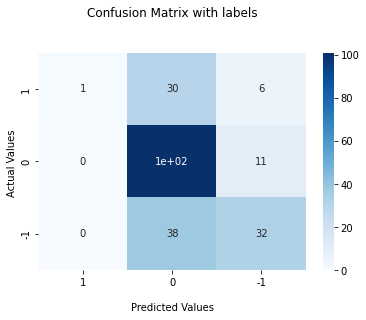

In [ ]:
tool.evaluate(y_val,rfPredictions)

In [ ]:
## random forest without hyperparameter tuning
rf = RandomForestClassifier(class_weight='balanced')
rf.fit(tfidf_X_train, y_train)
rfPredictions = rf.predict(tfidf_X_val)
metricsReport("random forest", 'overall',y_val, rfPredictions)

------random forest--overall-- Model Metrics-----
Accuracy: 0.5982
Balanced_Accuracy: 0.4459
Hamming Loss: 0.4018
Precision:
  - Macro: 0.7409
  - Micro: 0.5982
 - Weighted: 0.6721
Recall:
  - Macro: 0.4459
  - Micro: 0.5982
Weighted: 0.5982
F1-measure:
  - Macro: 0.4190
  - Micro: 0.5982
Weighted: 0.5307


Calculate roc_auc_score

In [ ]:
roc_auc_score(y_val, rf.predict_proba(tfidf_X_val), multi_class='ovr')

0.732155424498459

Split whole dataset into separate 10 topics and then use pre-trained random forest model to make predicitons on each topic individually.

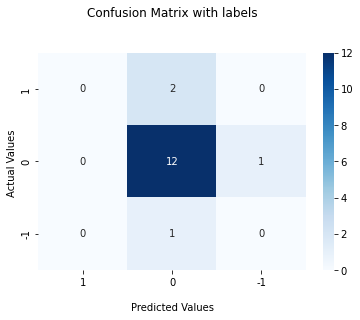

------random forest--financial markets-- Model Metrics-----
Accuracy: 0.7500
Balanced_Accuracy: 0.3077
Hamming Loss: 0.2500
Precision:
  - Macro: 0.2667
  - Micro: 0.7500
 - Weighted: 0.6500
Recall:
  - Macro: 0.3077
  - Micro: 0.7500
Weighted: 0.7500
F1-measure:
  - Macro: 0.2857
  - Micro: 0.7500
Weighted: 0.6964


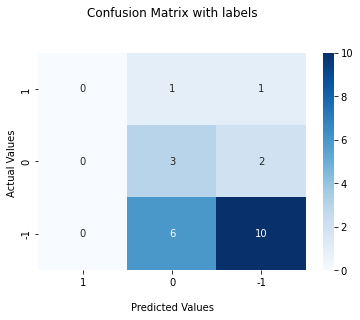

------random forest--geopolitical uncertainty-- Model Metrics-----
Accuracy: 0.5652
Balanced_Accuracy: 0.4083
Hamming Loss: 0.4348
Precision:
  - Macro: 0.3564
  - Micro: 0.5652
 - Weighted: 0.6003
Recall:
  - Macro: 0.4083
  - Micro: 0.5652
Weighted: 0.5652
F1-measure:
  - Macro: 0.3632
  - Micro: 0.5652
Weighted: 0.5667


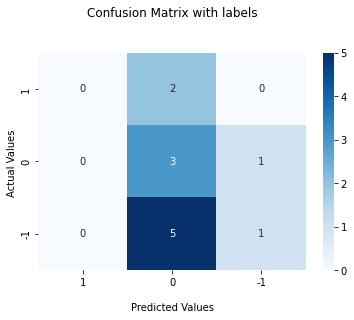

------random forest--growth-- Model Metrics-----
Accuracy: 0.3333
Balanced_Accuracy: 0.3056
Hamming Loss: 0.6667
Precision:
  - Macro: 0.2667
  - Micro: 0.3333
 - Weighted: 0.3500
Recall:
  - Macro: 0.3056
  - Micro: 0.3333
Weighted: 0.3333
F1-measure:
  - Macro: 0.2262
  - Micro: 0.3333
Weighted: 0.2679


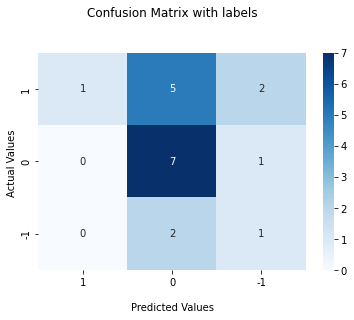

------random forest--housing-- Model Metrics-----
Accuracy: 0.4737
Balanced_Accuracy: 0.4444
Hamming Loss: 0.5263
Precision:
  - Macro: 0.5833
  - Micro: 0.4737
 - Weighted: 0.6711
Recall:
  - Macro: 0.4444
  - Micro: 0.4737
Weighted: 0.4737
F1-measure:
  - Macro: 0.3814
  - Micro: 0.4737
Weighted: 0.4066


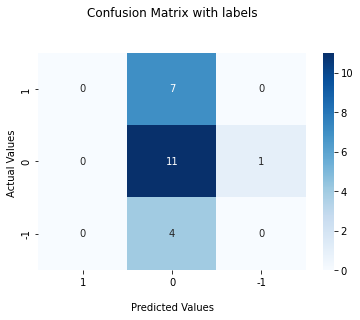

------random forest--inflation-- Model Metrics-----
Accuracy: 0.4783
Balanced_Accuracy: 0.3056
Hamming Loss: 0.5217
Precision:
  - Macro: 0.1667
  - Micro: 0.4783
 - Weighted: 0.2609
Recall:
  - Macro: 0.3056
  - Micro: 0.4783
Weighted: 0.4783
F1-measure:
  - Macro: 0.2157
  - Micro: 0.4783
Weighted: 0.3376


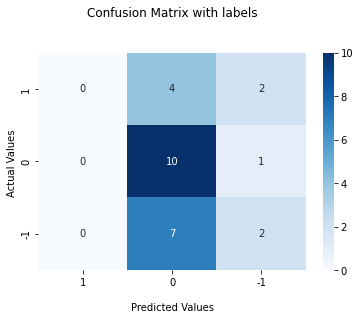

------random forest--labor market-- Model Metrics-----
Accuracy: 0.4615
Balanced_Accuracy: 0.3771
Hamming Loss: 0.5385
Precision:
  - Macro: 0.2921
  - Micro: 0.4615
 - Weighted: 0.3399
Recall:
  - Macro: 0.3771
  - Micro: 0.4615
Weighted: 0.4615
F1-measure:
  - Macro: 0.3036
  - Micro: 0.4615
Weighted: 0.3633


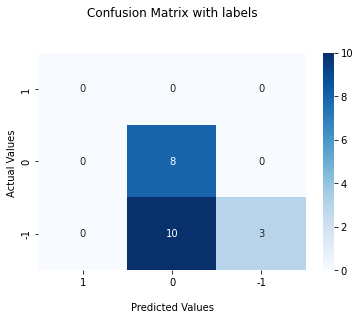

------random forest--quantitative easing-- Model Metrics-----
Accuracy: 0.5238
Balanced_Accuracy: 0.6154
Hamming Loss: 0.4762
Precision:
  - Macro: 0.7222
  - Micro: 0.5238
 - Weighted: 0.7884
Recall:
  - Macro: 0.6154
  - Micro: 0.5238
Weighted: 0.5238
F1-measure:
  - Macro: 0.4952
  - Micro: 0.5238
Weighted: 0.4666


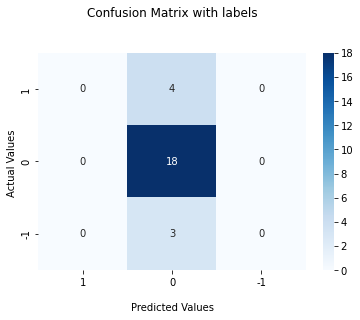

------random forest--credit-- Model Metrics-----
Accuracy: 0.7200
Balanced_Accuracy: 0.3333
Hamming Loss: 0.2800
Precision:
  - Macro: 0.2400
  - Micro: 0.7200
 - Weighted: 0.5184
Recall:
  - Macro: 0.3333
  - Micro: 0.7200
Weighted: 0.7200
F1-measure:
  - Macro: 0.2791
  - Micro: 0.7200
Weighted: 0.6028


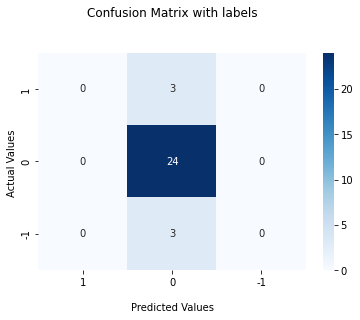

------random forest--fed funds rate-- Model Metrics-----
Accuracy: 0.8000
Balanced_Accuracy: 0.3333
Hamming Loss: 0.2000
Precision:
  - Macro: 0.2667
  - Micro: 0.8000
 - Weighted: 0.6400
Recall:
  - Macro: 0.3333
  - Micro: 0.8000
Weighted: 0.8000
F1-measure:
  - Macro: 0.2963
  - Micro: 0.8000
Weighted: 0.7111


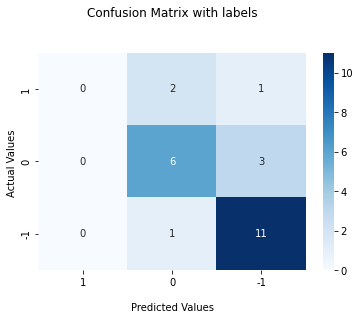

------random forest--liquidity measures-- Model Metrics-----
Accuracy: 0.7083
Balanced_Accuracy: 0.5278
Hamming Loss: 0.2917
Precision:
  - Macro: 0.4667
  - Micro: 0.7083
 - Weighted: 0.6167
Recall:
  - Macro: 0.5278
  - Micro: 0.7083
Weighted: 0.7083
F1-measure:
  - Macro: 0.4938
  - Micro: 0.7083
Weighted: 0.6574


In [ ]:
for t in ['financial markets','geopolitical uncertainty','growth','housing','inflation','labor market','quantitative easing','credit','fed funds rate','liquidity measures']:
  y =  y_val.index.get_indexer_for(y_val[df_train.loc[y_val.index].topic == t].index)
  rfPredictions = rf.predict(tfidf_X_val[y,:])
  tool.evaluate(y_val[df_train.loc[y_val.index].topic == t], rfPredictions)

  metricsReport("random forest", t,y_val[df_train.loc[y_val.index].topic == t], rfPredictions)